In [1]:
from cytograph import Algorithm, creates, requires, div0
from cytograph.visualization.scatter import scatterc, scattern
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import List
import shoji
import cytograph as cg
import cytograph.visualization as cgplot
import collections
from typing import List, Optional
import matplotlib.patheffects as PathEffects
import fastcluster
import igraph
import leidenalg as la
import scipy.cluster.hierarchy as hc
from hmmlearn import hmm
from openTSNE import TSNE
from pynndescent import NNDescent
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from tqdm import trange
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from cytograph.visualization import Colorizer
from matplotlib.lines import Line2D
import scanpy as sc
import loompy
import infercnvpy as cnv

In [2]:
db = shoji.connect()

In [3]:
ws = db.builds.jesper.GBM_all.SL057_filtered

In [39]:
Z = ["mediumblue", # Cortex - gray
 "royalblue", #Periphery - blue
 "#B15297", #Low - purple
"deeppink", #High - pink
 "hotpink"] #Necrotic core - black

In [40]:
col = []
FL = ws.Sample[:]
for x in FL:
    if x == 'SL057A':
        col.append(Z[3])
    elif x == 'SL057B':
        col.append(Z[4])
    elif x == 'SL057C':
        col.append(Z[1])
    elif x == 'SL057D':
        col.append(Z[0])

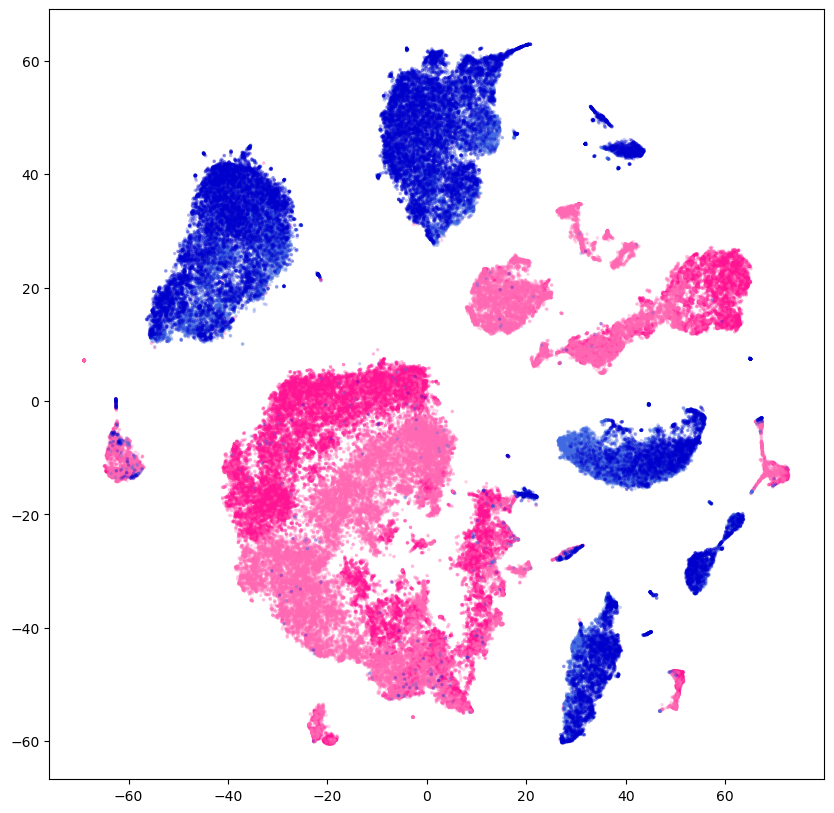

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(ws.Embedding[:, 0], ws.Embedding[:, 1], c=col, s=6, lw=0, alpha=0.3, rasterized=True)
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL057/SL057_zones_colors_new.pdf", dpi=300, bbox_inches="tight")

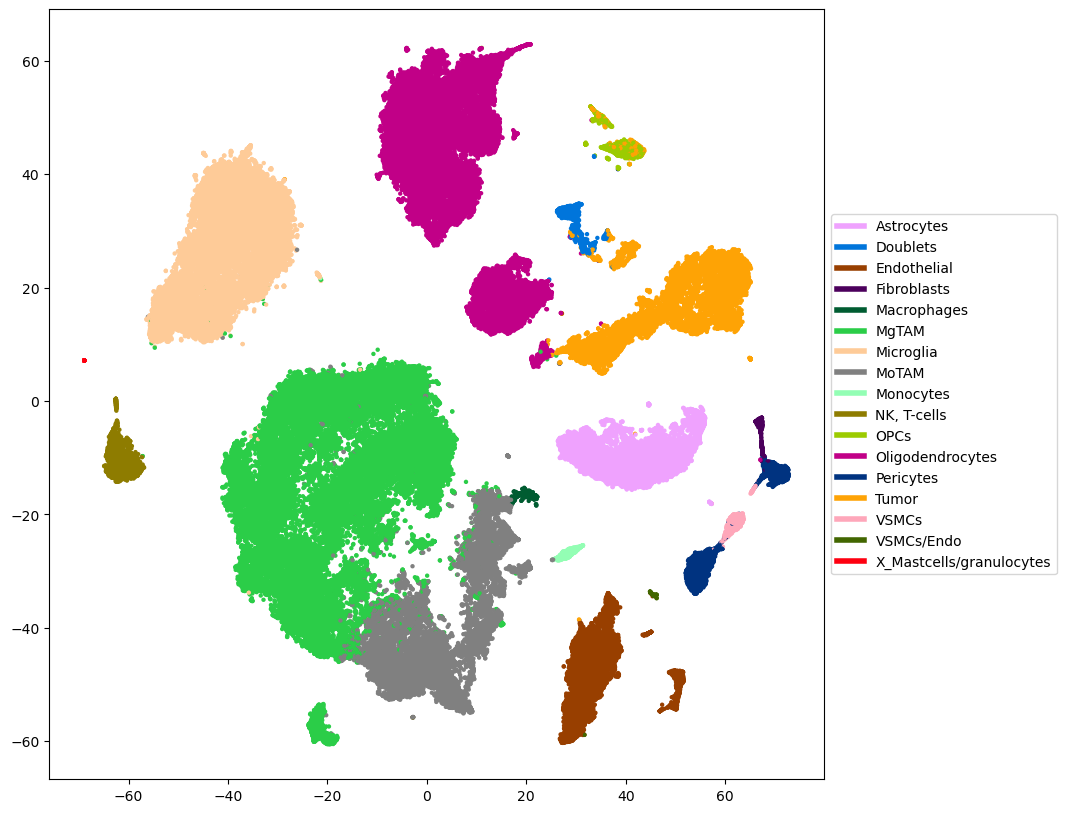

In [7]:
ws = db.builds.jesper.GBM_all.SL057_filtered
plt.figure(figsize=(10,10))
cgplot.scatterc(ws.Embedding[:], c=ws.ManualAnnotationSL057_MAC[:], s=10)
#plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL057/SL057_Annotation_labels_on.pdf", dpi=300)

In [9]:
labels2 = [
    'Monocytes',
    'Macrophages',
    'moTAM',
    'mgTAM',
    'Microglia',
    'Oligodendrocytes',
    'Astrocytes',
    'Tumor',
    'Other']

In [7]:
Z =["#a580ad",
    "#c7bd80", #"#e9d78e",
[0.99609375, 0.796875, 0.59765625],#"#6f3d94",
 "#b36305", #"#6f3d94",
"#ee7c0e",#[0.578125, 0.99609375, 0.70703125], #"#ffd300", #"#6f3d94",
"#000000",
'#4574b3',
 "#74c493", #"#e0598b"
"#bfbfbf"]

In [12]:
palette_classes = {'Astrocytes':'#4574b3',
 'B_Tumor+Astro?+OPC?+doublet?': [0.0, 0.45703125, 0.859375],
 'Endothelial': [0.59765625, 0.24609375, 0.0],
 'Fibroblasts': [0.296875, 0.0, 0.359375],
 'Macrophages': "#c7bd80",#"#e9d78e",
 'Microglia': "#ee7c0e",#[0.578125, 0.99609375, 0.70703125], #"#ffd300", #"#6f3d94",
 'MoTAM': [0.99609375, 0.796875, 0.59765625], #"#6f3d94",
 'MgTAM':  "#b36305", #"#6f3d94",                 
 'Monocytes': "#a580ad",
 'NK, T-cells': [0.578125, 0.99609375, 0.70703125],
 'OPCs': [0.55859375, 0.484375, 0.0],
 'Oligodendrocytes': "#000000",
 'Pericytes': [0.7578125, 0.0, 0.53125],
 'Tumor': "#74c493", #"#e0598b"
 'VSMC': [0.99609375, 0.640625, 0.01953125]}

In [8]:
Right_order = ['Monocytes','Macrophages','MoTAM','MgTAM','Microglia','Oligodendrocytes','Astrocytes']

In [36]:
col = []
FL = ws.ManualAnnotationSL057_MAC[:]
for x in FL:
    if x == 'Monocytes':
        col.append(Z[0])
    elif x == 'Macrophages':
        col.append(Z[1])
    elif x == 'MoTAM':
        col.append(Z[2])
    elif x == 'MgTAM':
        col.append(Z[3])
    elif x == 'Microglia':
        col.append(Z[4])
    elif x == 'Oligodendrocytes':
        col.append(Z[5])
    elif x == 'Astrocytes':
        col.append(Z[6])
    elif x == 'Tumor':
        col.append(Z[7])
    else:
        col.append(Z[8])

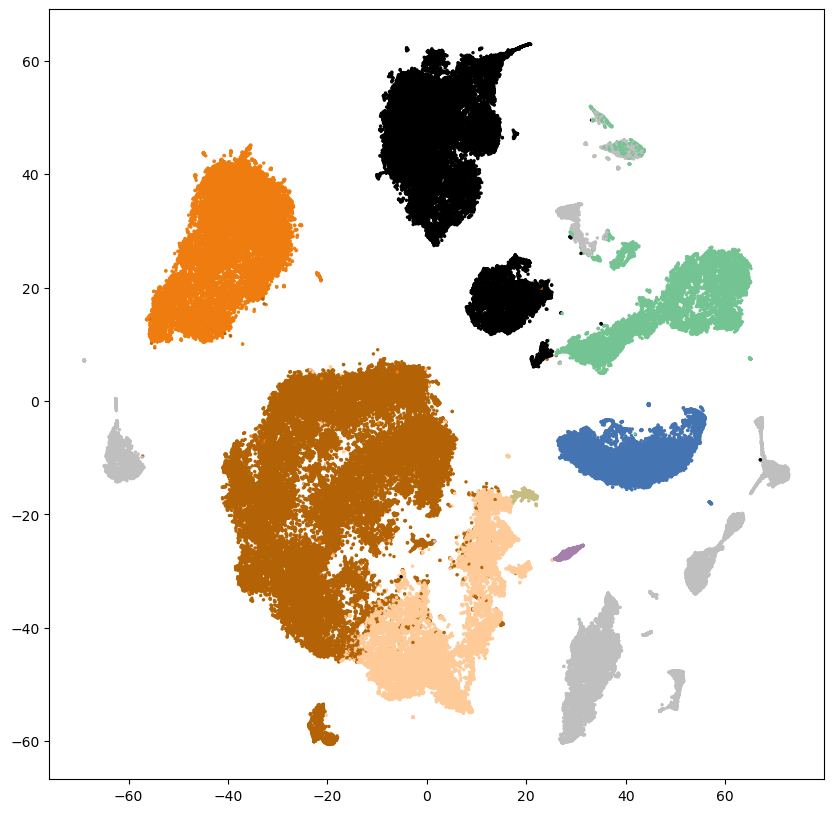

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(ws.Embedding[:, 0], ws.Embedding[:, 1], c=col, s=6, lw=0, alpha=0.3, rasterized=True)
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL057/SL057_tSNE_colors_new.pdf", dpi=300, bbox_inches="tight")

CPU times: user 6.7 s, sys: 1.7 s, total: 8.4 s
Wall time: 11.1 s


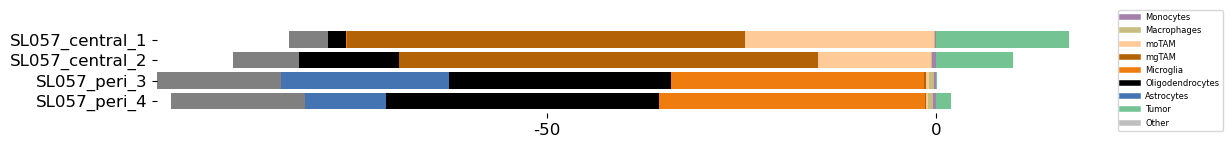

In [16]:
%%time
S = []
#Samples = np.unique(ws.Zone[:])
ws = db.builds.jesper.GBM_all.SL057_filtered
Samples = ['SL057A', 'SL057B', 'SL057C', 'SL057D']
unique_samples = ['SL057_central_1', 'SL057_central_2', 'SL057_peri_3', 'SL057_peri_4']
unique_samples = np.flip(unique_samples)
Samples = np.flip(Samples)
Samples = np.array(Samples, dtype=object)
unique_samples = np.array(unique_samples, dtype=object)
labels = np.unique(ws.ManualAnnotationSL057_MAC[:])
for i, sample in enumerate(Samples):
    Man = ws.ManualAnnotationSL057_MAC[:][ws.Sample[:] == sample]
    Sum = []
    for x in labels:
        Sum.append(np.sum(np.isin(Man, x)))
    Percent = []
    tot = np.sum(Sum)
    for x in Sum:
        roundedNumber = round(x/tot * 100, 3)
        Perc = str(roundedNumber) + "%"
        Percent.append(roundedNumber)
    size = np.array(Percent)
    S.append(size)
df = pd.DataFrame(S, columns=labels,  index=unique_samples)
nontumor_bars = df.drop(['B_Tumor+Astro?+OPC?+doublet?','Endothelial','Fibroblasts','NK, T-cells','OPCs','Pericytes','VSMCs', 'VSMCs/Endo','X_Mastcells/granulocytes','Tumor'], axis=1)
other_bars = df[['B_Tumor+Astro?+OPC?+doublet?','Endothelial','Fibroblasts','NK, T-cells','OPCs','Pericytes','VSMCs', 'VSMCs/Endo','X_Mastcells/granulocytes']]
tumor_bars = df[["Tumor"]]
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(10, 1.15))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_xticks([-50,0,50])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 

ax1.set_xticklabels([-50,0,50],fontsize=12)

for i, ct in enumerate(Right_order):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=palette_classes[ct])
    left += nontumor_bars[ct]
for i, ct in enumerate(other_bars):
    #ax1.bar(unique_samples,height=-other_bars[ct],bottom=-bottom, color=[0.5, 0.5, 0.5])
    #bottom += other_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-other_bars[ct],left=-left, color=[0.5, 0.5, 0.5])
    left += other_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=palette_classes[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in Z]
ax1.legend(hidden_lines,labels2, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12) 
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL057/SL057_barpot_colors_new.pdf", dpi=300, bbox_inches="tight")

CPU times: user 6.66 s, sys: 1.73 s, total: 8.39 s
Wall time: 10.5 s


[Text(0, 0, 'SL057_peri_4'),
 Text(0, 1, 'SL057_peri_3'),
 Text(0, 2, 'SL057_central_2'),
 Text(0, 3, 'SL057_central_1')]

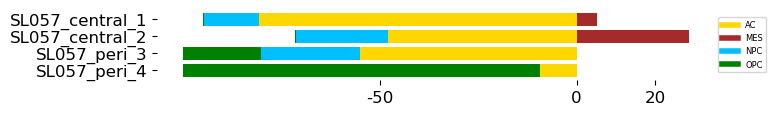

In [55]:
%%time
S = []
#Samples = np.unique(ws.Zone[:])
ws = db.builds.jesper.GBM_all.SL057_filtered
Samples = ['SL057A', 'SL057B', 'SL057C', 'SL057D']
unique_samples = ['SL057_central_1', 'SL057_central_2', 'SL057_peri_3', 'SL057_peri_4']
Samples = np.array(Samples, dtype=object)
Samples = np.flip(Samples)
unique_samples = np.array(unique_samples, dtype=object)
unique_samples = np.flip(unique_samples)
A = ['AC', 'MES', 'NPC', 'OPC']
labels = np.array(A, dtype=object)
for i, sample in enumerate(Samples):
    ac, mes, npc, opc = np.hsplit(ws.NeftelScore[ws.Sample[:] == sample][ws.ManualAnnotationSL057_new[ws.Sample[:] == sample] == 'Tumor'], 4)
    winnersAll = np.argmax([ac, mes, npc, opc], axis=0)
    Man = np.hstack(labels[winnersAll])
    Sum = []
    for x in labels:
        Sum.append(np.sum(np.isin(Man, x)))
    Percent = []
    tot = np.sum(Sum)
    for x in Sum:
        roundedNumber = round(x/tot * 100, 3)
        Perc = str(roundedNumber) + "%"
        Percent.append(roundedNumber)
    size = np.array(Percent)
    S.append(size)
df = pd.DataFrame(S, columns=labels,  index=unique_samples)
nontumor_bars = df.drop('MES', axis=1)
tumor_bars = df[["MES"]]
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(6, len(Samples)*0.25))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_xticks([-50,0,20])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 

ax1.set_xticklabels([-50,0,20],fontsize=12)
colors=["gold", "brown", "deepskyblue", "green"]
pcolors = dict(zip(labels, colors))

for i, ct in enumerate(nontumor_bars):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=pcolors[ct])
    left += nontumor_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=pcolors[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in colors]
ax1.legend(hidden_lines,labels, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12)
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL057/SL057_BarHorizontal_MetaModules_fraction_tumorcells_label.pdf", dpi=300, bbox_inches="tight")

In [4]:
celltype = ['Tumor', 'TAM', 'Oligodendrocytes']

In [5]:
MES1 = np.array(["CHI3L1","ANXA2","ANXA1","CD44","VIM","MT2A","C1S","NAMPT","EFEMP1","C1R","SOD2","IFITM3","TIMP1","SPP1","A2M","S100A11","MT1X","S100A10","FN1","LGALS1","S100A16","CLIC1","MGST1","RCAN1","TAGLN2","NPC2","SERPING1","TCIM","EMP1","APOE","CTSB","C3","LGALS3","MT1E","EMP3","SERPINA3","ACTN1","PRDX6","IGFBP7","SERPINE1","PLP2","MGP","CLIC4","GFPT2","GSN","NNMT","TUBA1C","GJA1","TNFRSF1A","WWTR1"])
MES2 = np.array(["HILPDA","ADM","DDIT3","NDRG1","HERPUD1","DNAJB9","TRIB3","ENO2","AKAP12","SQSTM1","MT1X","ATF3","NAMPT","NRN1","SLC2A1","BNIP3","LGALS3","INSIG2","IGFBP3","PPP1R15A","VIM","PLOD2","GBE1","SLC2A3","FTL","WARS1","ERO1A","XPOT","HSPA5","GDF15","ANXA2","EPAS1","LDHA","P4HA1","SERTAD1","PFKP","PGK1","EGLN3","SLC6A6","CA9","BNIP3L","RPL21","TRAM1","UFM1","ASNS","GOLT1B","ANGPTL4","SLC39A14","CDKN1A","HSPA9"])
gene_list = np.concatenate((MES1, MES2))
_, i = np.unique(gene_list, return_index=True)
gene_list = gene_list[np.sort(i)]
gene_list

array(['CHI3L1', 'ANXA2', 'ANXA1', 'CD44', 'VIM', 'MT2A', 'C1S', 'NAMPT',
       'EFEMP1', 'C1R', 'SOD2', 'IFITM3', 'TIMP1', 'SPP1', 'A2M',
       'S100A11', 'MT1X', 'S100A10', 'FN1', 'LGALS1', 'S100A16', 'CLIC1',
       'MGST1', 'RCAN1', 'TAGLN2', 'NPC2', 'SERPING1', 'TCIM', 'EMP1',
       'APOE', 'CTSB', 'C3', 'LGALS3', 'MT1E', 'EMP3', 'SERPINA3',
       'ACTN1', 'PRDX6', 'IGFBP7', 'SERPINE1', 'PLP2', 'MGP', 'CLIC4',
       'GFPT2', 'GSN', 'NNMT', 'TUBA1C', 'GJA1', 'TNFRSF1A', 'WWTR1',
       'HILPDA', 'ADM', 'DDIT3', 'NDRG1', 'HERPUD1', 'DNAJB9', 'TRIB3',
       'ENO2', 'AKAP12', 'SQSTM1', 'ATF3', 'NRN1', 'SLC2A1', 'BNIP3',
       'INSIG2', 'IGFBP3', 'PPP1R15A', 'PLOD2', 'GBE1', 'SLC2A3', 'FTL',
       'WARS1', 'ERO1A', 'XPOT', 'HSPA5', 'GDF15', 'EPAS1', 'LDHA',
       'P4HA1', 'SERTAD1', 'PFKP', 'PGK1', 'EGLN3', 'SLC6A6', 'CA9',
       'BNIP3L', 'RPL21', 'TRAM1', 'UFM1', 'ASNS', 'GOLT1B', 'ANGPTL4',
       'SLC39A14', 'CDKN1A', 'HSPA9'], dtype='<U8')

CPU times: user 35min 10s, sys: 8min 46s, total: 43min 57s
Wall time: 56min 48s


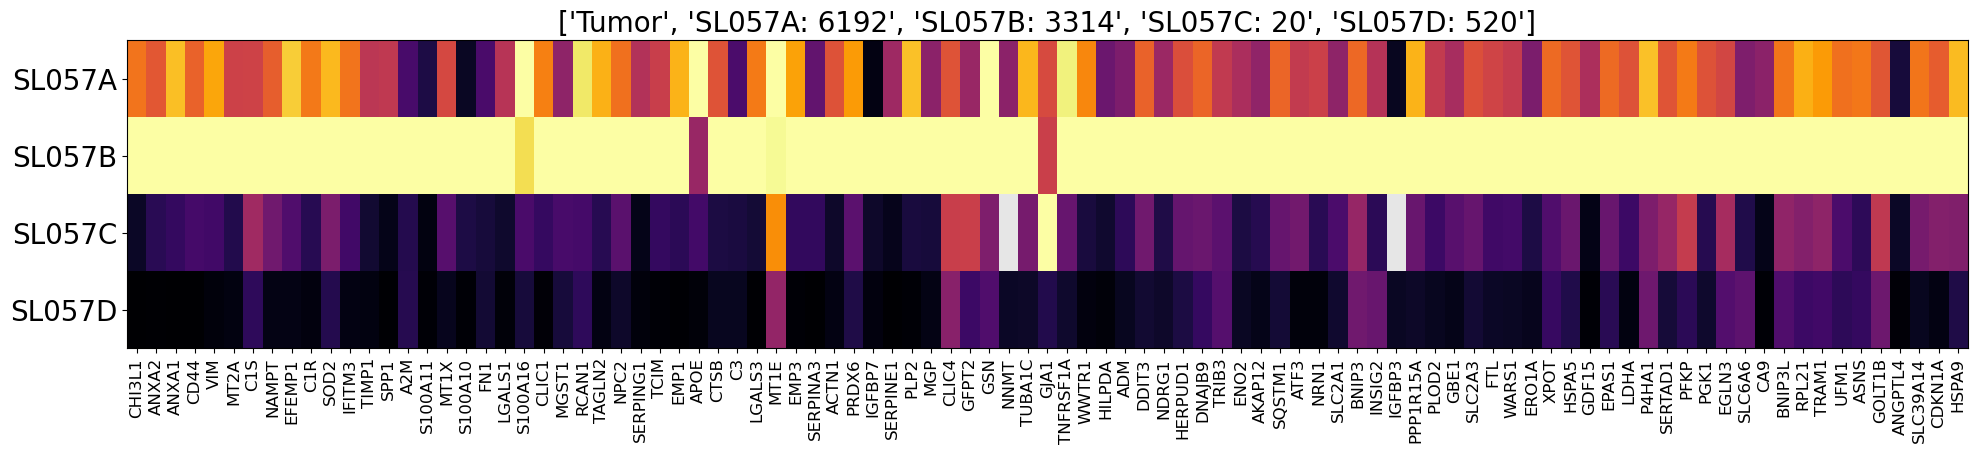

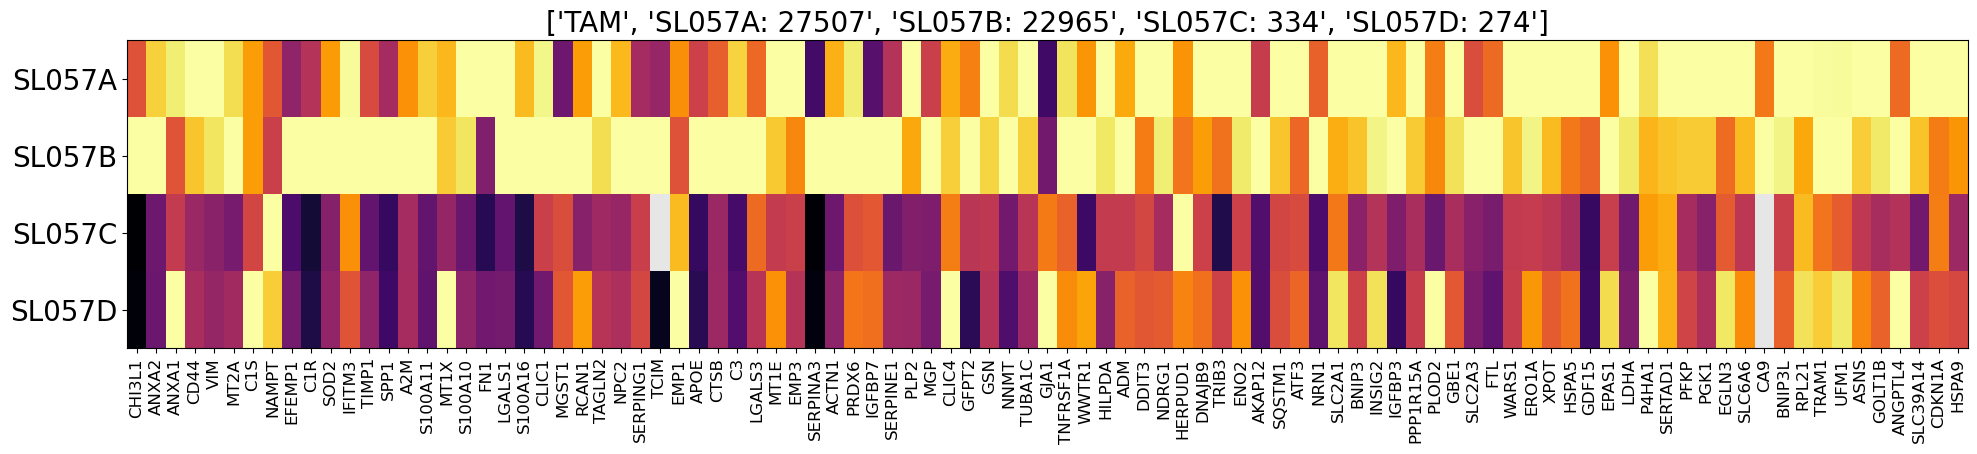

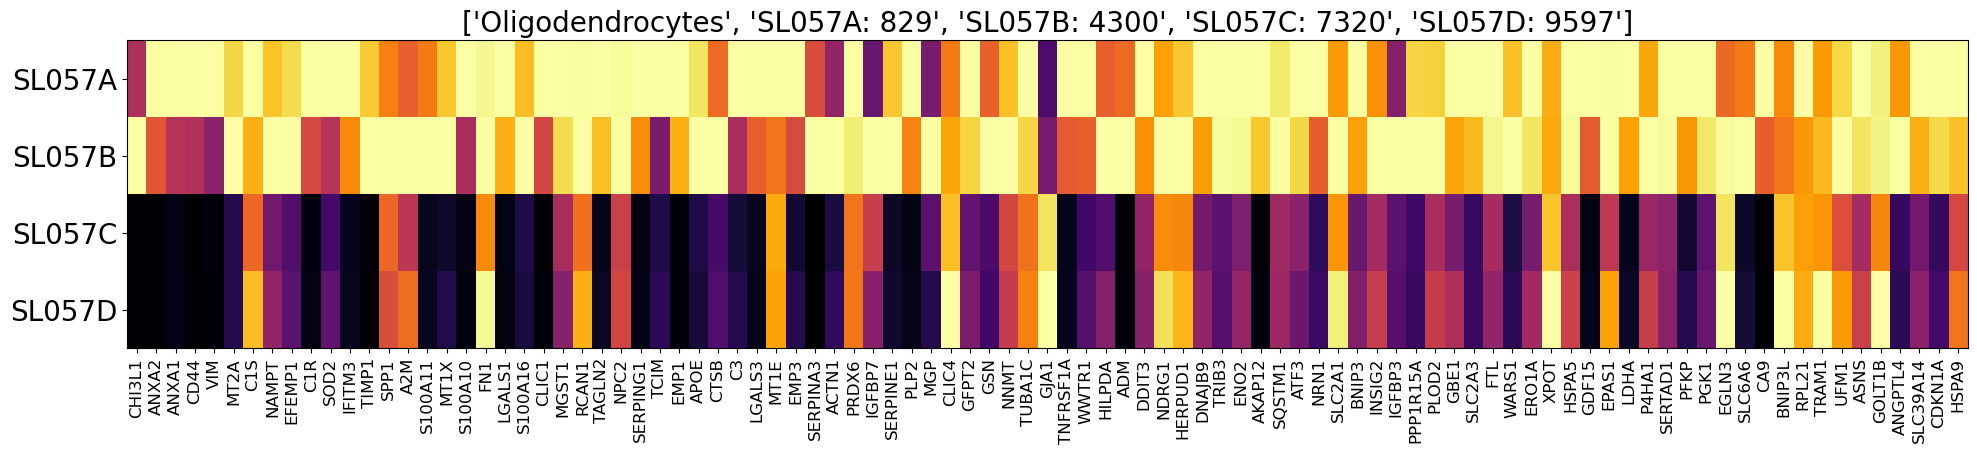

In [7]:
%%time
#Heatmap for all cell types, normalized internally
#celltype = np.unique(ws.ManualAnnotationSL057_TAM[:])
Samples = ['SL057A', 'SL057B', 'SL057C', 'SL057D']
Samples = np.array(Samples, dtype=object)
for cell in celltype:
    Sum = [cell]
    unique_samples = []
    for i, sample in enumerate(Samples):
        Su = np.sum(ws.ManualAnnotationSL057_TAM[ws.Sample[:] == sample] == cell)
        Sum.append(sample + ": " + str(Su))
        if Su > 0:
            unique_samples.append(sample)
    n_genes = len(gene_list)
    n_clusters = len(unique_samples)
    x = np.zeros((n_genes, n_clusters))
    for i, gene in enumerate(gene_list):
        gene_ix = np.where(ws.Gene[:] == gene)[0][0]
        for n, sample in enumerate(unique_samples):
            x[i, n] = np.mean(ws.Expression[:, ws.Gene == str(gene)][ws.Sample[:] == sample][ws.ManualAnnotationSL057_TAM[ws.Sample[:] == sample] == cell])

    # Normalize
    totals = x.sum(axis=1)
    xY = (x.T / totals * np.median(totals)).T
    xY = cg.div0(xY.T, np.percentile(xY, 99.5, axis=1)).T

    # Make background grey for zeros
    xY = xY.T
    G = xY
    bg = np.zeros_like(xY) + 0.9
    xY = np.ma.masked_where(xY == 0, xY)
    plt.figure(None, (n_genes / 4, 4))
    plt.imshow(bg[:], vmin=0, vmax=1, cmap=plt.cm.gray, aspect="auto")
    plt.imshow(xY[:], cmap="inferno", vmin=0, vmax=1, interpolation= "nearest", aspect="auto", alpha=1)
    plt.xticks(ticks=range(n_genes),labels=gene_list, fontsize=12, rotation=90)
    plt.yticks(ticks=range(n_clusters), labels=unique_samples, fontsize=20)
    plt.title(list(Sum),fontsize=20)
    #plt.colorbar()
    None
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Heatmap_MES_nonNormalized" + cell + "_57.pdf",dpi=300, bbox_inches="tight")

In [6]:
adata = sc.read_h5ad("/proj/cytograph/jesper/GBM_SL057_filtered")

In [7]:
adata.var_names_make_unique()

In [8]:
adata.var["chromosome"] = adata.var["Chromosome"]
adata.var["start"] = adata.var["Start"]
adata.var["end"] = adata.var["End"]
adata.var["ensg"] = adata.var["Accession_copy"]

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [10]:
cnv.tl.infercnv(adata, window_size=500, exclude_chromosomes=('', 'GL000009.2', 'GL000194.1', 'GL000195.1', 'GL000205.2',
       'GL000213.1', 'GL000216.2', 'GL000218.1', 'GL000219.1',
       'GL000220.1', 'GL000225.1', 'KI270442.1', 'KI270711.1',
       'KI270713.1', 'KI270721.1', 'KI270726.1', 'KI270727.1',
       'KI270728.1', 'KI270731.1', 'KI270733.1', 'KI270734.1',
       'KI270744.1', 'KI270750.1','chrM','chrY'), reference_key="ManualAnnotationSL057_new",reference_cat=["Astrocytes", "Microglia","MgTAM", "Oligodendrocytes", "Endothelial"])

  0%|          | 0/25 [00:00<?, ?it/s]

{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: ylabel='AneuploidMeta_new'>,
 'gene_groups_ax': <Axes: >}

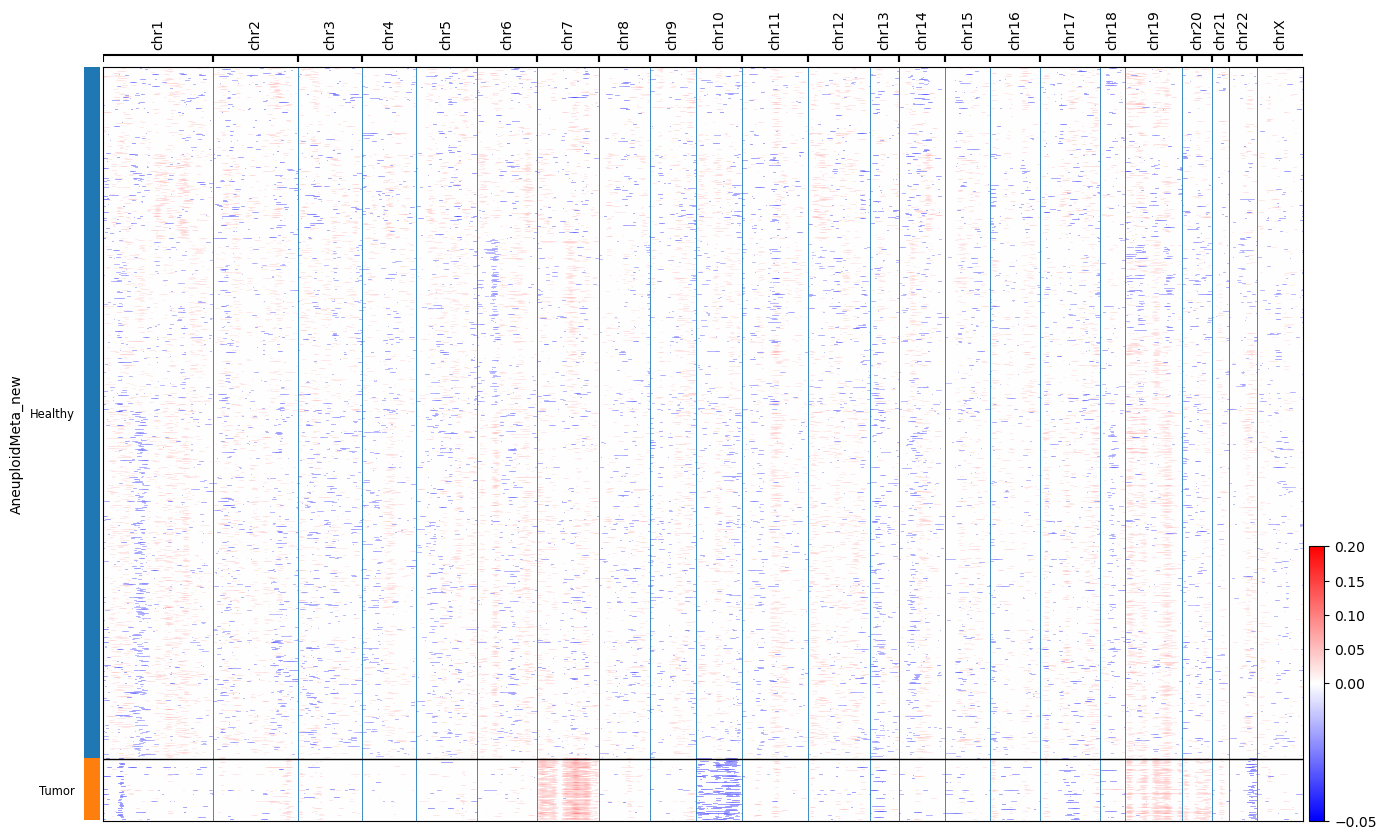

In [13]:
cnv.pl.chromosome_heatmap(adata, groupby="AneuploidMeta_new", show=False, cmap='bwr',vmin = -0.05, vmax = 0.2)